In [3]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import jit, random

from tinygp import GaussianProcess, kernels
from stingray import Lightcurve

jax.config.update("jax_enable_x64", True)

import functools

import tensorflow_probability.substrates.jax as tfp
tfpd = tfp.distributions
tfpb = tfp.bijectors

from jaxns import ExactNestedSampler
from jaxns import TerminationCondition
# from jaxns import analytic_log_evidence
from jaxns import Prior, Model
import tinygp

In [8]:
def get_kernel(kernel_type, kernel_params):
    if kernel_type == "QPO_plus_RN":
        kernel = tinygp.kernels.quasisep.Exp(
            scale=1 / kernel_params["crn"], sigma=(kernel_params["arn"]) ** 0.5
        ) + tinygp.kernels.quasisep.Celerite(
            a=kernel_params["aqpo"],
            b=0.0,
            c=kernel_params["cqpo"],
            d=2 * jnp.pi * kernel_params["freq"],
        )
        return kernel
    elif kernel_type == "RN":
        kernel = tinygp.kernels.quasisep.Exp(
            scale=1 / kernel_params["crn"], sigma=(kernel_params["arn"]) ** 0.5
        )
        return kernel
    
def get_mean(mean_type, mean_params):
    if mean_type == "gaussian":
        mean = functools.partial(_gaussian, mean_params=mean_params)
    elif mean_type == "skew_gaussian":
        mean = functools.partial(_skew_gaussian, mean_params=mean_params)
    return mean

def _gaussian(t, mean_params):
    A = jnp.atleast_1d(mean_params["A"])[:,jnp.newaxis]
    t0 = jnp.atleast_1d(mean_params["t0"])[:,jnp.newaxis]
    sig = jnp.atleast_1d(mean_params["sig"])[:,jnp.newaxis]

    return jnp.sum (A * jnp.exp(
        -((t - t0) ** 2) / (2 * (sig ** 2))
    )
    , axis=0)

def _skew_gaussian(t, mean_params):
    return mean_params["A"] * jnp.where(
        t > mean_params["t0"],
        jnp.exp(-((t - mean_params["t0"]) ** 2) / (2 * (mean_params["sig2"] ** 2))),
        jnp.exp(-((t - mean_params["t0"]) ** 2) / (2 * (mean_params["sig1"] ** 2))),
    )
### SIMPLIFIED IMPLIMENTATION ###
### ------------------------------------------------------------------ ###
def get_kernel_params(kernel_type):
    if kernel_type == "RN":
        return ['arn','crn']
    elif kernel_type == "QPO_plus_RN":
        return ['arn','crn', 'aqpo', 'cqpo', 'freq']

def get_mean_params(mean_type):
    if (mean_type == "gaussian") or (mean_type == "exponential"):
        return ['A', 't0', 'sig']
    elif (mean_type == "skew_gaussian") or (mean_type == "skew_exponential"):
        return ['A', 't0', 'sig1', 'sig2']

def get_gp_params(kernel_type, mean_type):
    kernel_params = get_kernel_params(kernel_type)
    mean_params = get_mean_params(mean_type)
    kernel_params.extend(mean_params)
    return kernel_params

param_dict = {"A": tfpd.Uniform(0, 2), "arn" : tfpd.Uniform(0.1, 2), 
             "sig": tfpd.Uniform(0, 2), "crn": tfpd.Uniform(0, 3),"t0": tfpd.Uniform(0, 2)}

def get_prior(params_list, **kwargs):
    def prior_model():
        prior_list = []
        for i in params_list:
            parameter = yield Prior (kwargs[i], name = i)
            prior_list.append(parameter)
        return tuple(prior_list)
    return prior_model

def get_likelihood(params_list, **kwargs):
    def likelihood_model(*args):    
        dict = {}
        for i, params in enumerate(params_list):
            dict[params] = args[i]
        # Do something with the dictionary to calculate log_likelihood
        return -1.5 
    
    return likelihood_model

params_list = get_gp_params(kernel_type="RN", mean_type="gaussian")
prior_model = get_prior(params_list, **param_dict)
likelihood_model = get_likelihood(params_list)

model = Model(prior_model, likelihood_model)
model.sanity_check(random.PRNGKey(10), S=100)


INFO[2023-06-22 00:58:21,254]: Sanity check...
INFO[2023-06-22 00:58:21,597]: Sanity check passed


In [13]:
### MORE COMPLETE IMPLEMENTATION ###

def get_kernel(kernel_type, kernel_params):
    if kernel_type == "QPO_plus_RN":
        kernel = tinygp.kernels.quasisep.Exp(
            scale=1 / kernel_params["crn"], sigma=(kernel_params["arn"]) ** 0.5
        ) + tinygp.kernels.quasisep.Celerite(
            a=kernel_params["aqpo"],
            b=0.0,
            c=kernel_params["cqpo"],
            d=2 * jnp.pi * kernel_params["freq"],
        )
        return kernel
    elif kernel_type == "RN":
        kernel = tinygp.kernels.quasisep.Exp(
            scale=1 / kernel_params["crn"], sigma=(kernel_params["arn"]) ** 0.5
        )
        return kernel
    
def get_mean(mean_type, mean_params):
    if mean_type == "gaussian":
        mean = functools.partial(_gaussian, mean_params=mean_params)
    elif mean_type == "skew_gaussian":
        mean = functools.partial(_skew_gaussian, mean_params=mean_params)
    return mean

def _gaussian(t, mean_params):
    A = jnp.atleast_1d(mean_params["A"])[:,jnp.newaxis]
    t0 = jnp.atleast_1d(mean_params["t0"])[:,jnp.newaxis]
    sig = jnp.atleast_1d(mean_params["sig"])[:,jnp.newaxis]

    return jnp.sum (A * jnp.exp(
        -((t - t0) ** 2) / (2 * (sig ** 2))
    )
    , axis=0)

def _skew_gaussian(t, mean_params):
    return mean_params["A"] * jnp.where(
        t > mean_params["t0"],
        jnp.exp(-((t - mean_params["t0"]) ** 2) / (2 * (mean_params["sig2"] ** 2))),
        jnp.exp(-((t - mean_params["t0"]) ** 2) / (2 * (mean_params["sig1"] ** 2))),
    )

### --------------------------------------------------------------------------------------------------- ###
def get_kernel_params(kernel_type):
    if kernel_type == "RN":
        return ['arn','crn']
    elif kernel_type == "QPO_plus_RN":
        return ['arn','crn', 'aqpo', 'cqpo', 'freq']

def get_mean_params(mean_type):
    if (mean_type == "gaussian") or (mean_type == "exponential"):
        return ['A', 't0', 'sig']
    elif (mean_type == "skew_gaussian") or (mean_type == "skew_exponential"):
        return ['A', 't0', 'sig1', 'sig2']

def get_gp_params(kernel_type, mean_type):
    kernel_params = get_kernel_params(kernel_type)
    mean_params = get_mean_params(mean_type)
    kernel_params.extend(mean_params)
    return kernel_params

def get_kernel_priors(kernel_type, **kwargs):
    if kernel_type == "RN":
        return {"arn" : tfpd.Uniform(0.1, 2), "crn": tfpd.Uniform(0, 3), }
    elif kernel_type == "QPO_plus_RN":
        return {"arn" : tfpd.Uniform(0.1, 5), "freq": tfpd.Uniform(0.1, 30), 
                "aqpo": tfpd.Uniform(0.1, 5), "cqpo": tfpd.Uniform(0.1, 5), "crn": tfpd.Uniform(0, 5), }

def get_mean_priors(mean_type, **kwargs):
    if (mean_type == "gaussian"):
        return {"A": tfpd.Uniform(0, 5), "t0": tfpd.Uniform(0, 2), "sig": tfpd.Uniform(0, 3)}
    elif (mean_type == "skew_gaussian"):
        return {"A": tfpd.Uniform(0, 2), "t0": tfpd.Uniform(0, 2), "sig1": tfpd.Uniform(0, 2), "sig2": tfpd.Uniform(0, 2)}

def get_prior(kernel_type, mean_type, **kwargs):
    params_list = get_gp_params(kernel_type, mean_type)
    dict = {}
    dict.update(get_kernel_priors(kernel_type,**kwargs))
    dict.update(get_mean_priors(mean_type,**kwargs))
    def prior_model():
        prior_list = []
        for i in params_list:
            parameter = yield Prior (dict[i], name = i)
            prior_list.append(parameter)
        return tuple(prior_list)
    return prior_model

def get_likelihood(kernel_type, mean_type, **kwargs):
    params_list = get_gp_params(kernel_type, mean_type)
    def likelihood_model(*args):    
        dict = {}
        for i, params in enumerate(params_list):
            dict[params] = args[i]
        kernel = get_kernel(kernel_type=kernel_type, kernel_params=dict)
        mean = get_mean(mean_type=mean_type, mean_params=dict)
        gp = GaussianProcess(kernel, kwargs["Times"], mean_value=mean(kwargs["Times"]))
        return gp.log_probability(kwargs["counts"])

    return likelihood_model

# Making Data 
Times = np.linspace(0,1,256)

kernel = kernel = kernels.quasisep.Exp( scale = 1/jnp.exp(1.0), sigma = (jnp.exp(1.0))**0.5) + kernels.quasisep.Celerite(
                a = jnp.exp(-2), b = 0.0, c = jnp.exp(1), d = 2*jnp.pi*20)

mean = get_mean(mean_type = "gaussian",
            mean_params = {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), "sig" : jnp.array([0.2, 0.1]) })

hqpogp = tinygp.GaussianProcess( kernel, Times, mean_value = mean(Times) , diag = 0.01)
counts = hqpogp.sample(jax.random.PRNGKey(101))
lightcurve = Lightcurve(Times, counts)

prior_model = get_prior(kernel_type = "QPO_plus_RN", mean_type = "gaussian")
likelihood_model = get_likelihood(kernel_type = "QPO_plus_RN", mean_type = "gaussian", 
                                  Times = Times, counts = counts)
model = Model(prior_model, likelihood_model)
model.sanity_check(random.PRNGKey(10), S=100)

Exact_ns = ExactNestedSampler(model, num_live_points=500, max_samples=1e4)
Termination_reason, State = Exact_ns(
            random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
Results = Exact_ns.to_results(State, Termination_reason)

INFO[2023-06-22 01:13:06,982]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-06-22 01:13:06,982]: Checking if light curve is sorted.
INFO[2023-06-22 01:13:06,982]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation
INFO[2023-06-22 01:13:07,279]: Sanity check...
INFO[2023-06-22 01:13:07,281]: Sanity check passed


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 1313132
# samples: 7152
# slices: 489500.0
# slices / acceptance: 89.0
# likelihood evals / sample: 183.6
# likelihood evals / slice: 2.7
--------
logZ=-71.9 +- 0.12
H=72.0
ESS=1745
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: 2.1 +- 1.3 | 0.5 / 1.9 / 4.1 | 1.5 | 1.5
--------
aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
aqpo: 0.35 +- 0.58 | 0.11 / 0.17 / 0.64 | 0.12 | 0.12
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 3.25 +- 0.85 | 2.27 / 3.12 / 4.49 | 2.93 | 2.93
--------
cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cqpo: 2.3 +- 1.4 | 0.5 / 2.3 / 4.3 | 3.0 | 3.0
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 3.48 +- 0.87 | 2.37 / 3.44 / 4.69 | 3.52 | 3.52
--------
freq: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP 

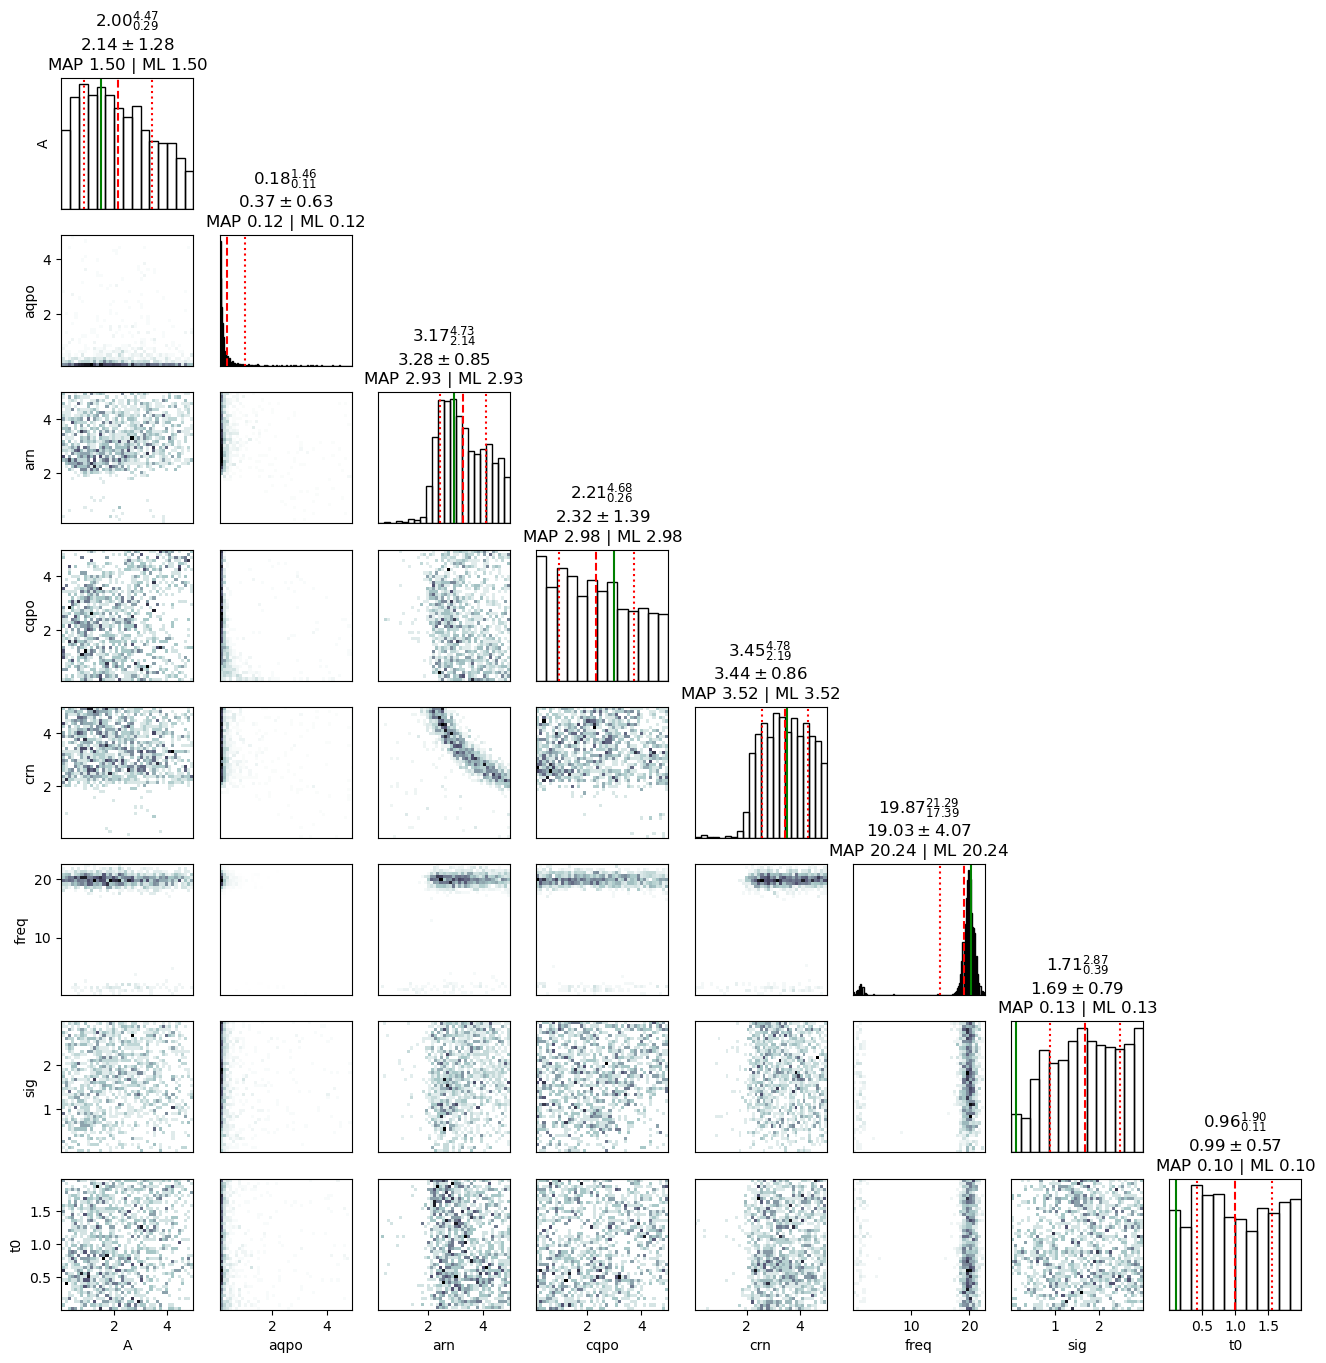

WARNING[2023-06-22 01:12:04,659]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


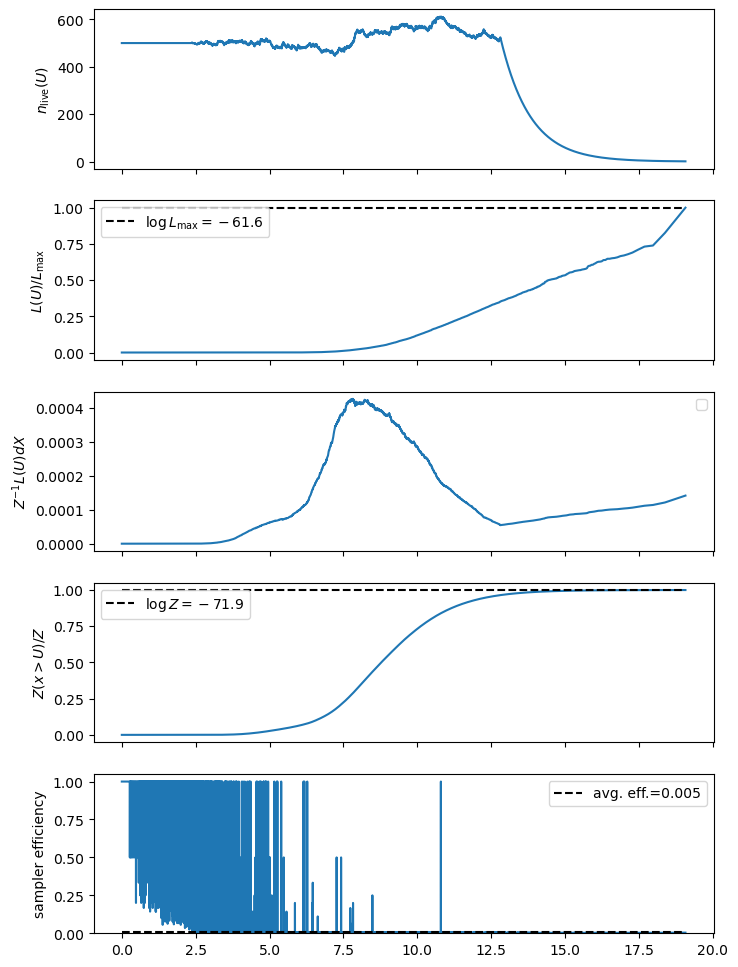

In [11]:
Exact_ns.summary(Results)
Exact_ns.plot_cornerplot(Results)